In [8]:
import os
import argparse
import random
from src.load.loader import load_all_chants, load_dkaaug_chants, load_sample_chants
from sklearn.model_selection import train_test_split
import json
from collections import Counter

LOAD_DATASET = {
    "all_antiphons": lambda chant_data_path, separated_cantus_ids_split, seed: load_all_chants(
        chant_data_path, "genre_a", False, separated_cantus_ids_split, seed=seed),
    "all_responsories": lambda chant_data_path, separated_cantus_ids_split, seed: load_all_chants(
        chant_data_path, "genre_r", False, separated_cantus_ids_split, seed=seed),
    "dkaaug_antiphons": lambda chant_data_path, separated_cantus_ids_split, seed: load_dkaaug_chants(
        chant_data_path, "genre_a", False, separated_cantus_ids_split, seed=seed),
    "dkaaug_responsories": lambda chant_data_path, separated_cantus_ids_split, seed: load_dkaaug_chants(
        chant_data_path, "genre_r", False, separated_cantus_ids_split, seed=seed),
    "sampled_antiphons": lambda chant_data_path, separated_cantus_ids_split, seed: load_sample_chants(
        chant_data_path, "genre_a", False, separated_cantus_ids_split, seed=seed, sample_size=1965),
    "sampled_responsories": lambda chant_data_path, separated_cantus_ids_split, seed: load_sample_chants(
        chant_data_path, "genre_r", False, separated_cantus_ids_split, seed=seed, sample_size=907),
}


def print_data_statistics(dataset_type, seed=0, separated_cantus_ids_split=False, data_path='./data/cantuscorpus-v0.2/csv/chant.csv'):
    random.seed(seed)

    # load data
    chants, modes = LOAD_DATASET[dataset_type](
        data_path, separated_cantus_ids_split, seed)
    train_x, test_x = chants
    train_y, test_y = modes

    all_modes = train_y + test_y
    counts = Counter(all_modes)
    for element in sorted(counts.keys()):
        print(f"{element}: {counts[element]}")
    

In [12]:
print("\n# All Antiphons")
print_data_statistics("all_antiphons")


print("\n# All Responsories")
print_data_statistics("all_responsories")


print("\n# D-KA Aug - Antiphons")
print_data_statistics("dkaaug_antiphons")


print("\n# D-KA Aug - Responsories")
print_data_statistics("dkaaug_responsories")


# All Antiphons
1: 3348
2: 979
3: 939
4: 1327
5: 522
6: 513
7: 2091
8: 3832

# All Responsories
1: 1258
2: 904
3: 679
4: 741
5: 443
6: 227
7: 1307
8: 1472

# D-KA Aug - Antiphons
1: 489
2: 120
3: 120
4: 264
5: 62
6: 81
7: 283
8: 546

# D-KA Aug - Responsories
1: 154
2: 122
3: 89
4: 109
5: 61
6: 28
7: 162
8: 182


# Generate Classification Scores

### Print Function

In [5]:
import os
import json
import glob
from collections import defaultdict

def print_classification_scores(directory, segmentation_approaches):
    # Initialize data structure to hold scores by language and experiment
    
    basic = defaultdict(dict)
    sci = defaultdict(dict)
    sciliq = defaultdict(dict)
    liq = defaultdict(dict)
    
    dataset_type_shortucts = {
        "all_antiphons": "all_a",
        "all_responsories": "all_r",
        "dkaaug_antiphons": "dka_a",
        "dkaaug_responsories": "dka_r",
        "sampled_antiphons": "sam_a",
        "sampled_responsories": "sam_r"
    }
    
    seg_approaches = set()
    header = set()
    
    # Load each JSON file in the directory
    for file_path in glob.glob(os.path.join(directory, "*.json")):   
        with open(file_path, 'r') as json_file:
            scores = json.load(json_file)
            seg_approach, representation, dataset_type, other_args = file_path.split("#")
            seg_approach = seg_approach.split('/')[-1]
            seg_approaches.add(seg_approach)
            header.add(dataset_type_shortucts[dataset_type] + " f1")
            header.add(dataset_type_shortucts[dataset_type] + " acc")
            
            if other_args == ".json":
                if not representation in basic:
                    basic[representation] = {}
                if not seg_approach in basic[representation]:
                    basic[representation][seg_approach] = {}
                basic[representation][seg_approach][dataset_type_shortucts[dataset_type] + " f1"] = round(100.0*scores["final"]["f1"], 1)
                basic[representation][seg_approach][dataset_type_shortucts[dataset_type] + " acc"] = round(100.0*scores["final"]["accuracy"], 1)
            elif other_args == "sci.json":
                if not representation in sci:
                    sci[representation] = {}
                if not seg_approach in sci[representation]:
                    sci[representation][seg_approach] = {}
                sci[representation][seg_approach][dataset_type_shortucts[dataset_type] + " f1"] = round(100.0*scores["final"]["f1"], 1)
                sci[representation][seg_approach][dataset_type_shortucts[dataset_type] + " acc"] = round(100.0*scores["final"]["accuracy"], 1)
            elif other_args == "liq.json":
                if not representation in liq:
                    liq[representation] = {}
                if not seg_approach in liq[representation]:
                    liq[representation][seg_approach] = {}
                liq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " f1"] = round(100.0*scores["final"]["f1"], 1)
                liq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " acc"] = round(100.0*scores["final"]["accuracy"], 1)
            elif other_args == "sciliq.json":
                if not representation in sciliq:
                    sciliq[representation] = {}
                if not seg_approach in sciliq[representation]:
                    sciliq[representation][seg_approach] = {}
                sciliq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " f1"] = round(100.0*scores["final"]["f1"], 1)
                sciliq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " acc"] = round(100.0*scores["final"]["accuracy"], 1)
    
    
    if segmentation_approaches == None:
        seg_approaches = sorted(list(seg_approaches))
    else:
        seg_approaches = segmentation_approaches
    header = sorted(list(header))
    
    
    def print_md_table(data, header, columns, experiment_name): 
        # Create Markdown table header with languages as columns
        md_table = f"| {experiment_name} | " + " | ".join(header) + " |\n"
        md_table += "|---" * (len(header) + 1) + "|\n"
        
        # Populate table rows by experiment in the order defined by experiment_shortcuts
        for col in columns:
            if not col in data:
                continue
            row = [col]
            for topic in header:
                # Get the score for each language or fill with 'N/A' if missing
                score = data[col].get(topic, "N/A")
                row.append(str(score))
            md_table += "| " + " | ".join(row) + " |\n"
        
        # Print the formatted Markdown table
        print(md_table)
    
    for rep in basic:
        print()
        print(" # " + rep.replace("_", " ").upper())
        print()
        print_md_table(basic[rep], header, seg_approaches, rep + " default")
        print_md_table(liq[rep], header, seg_approaches, rep + " liq")
        print_md_table(sci[rep], header, seg_approaches, rep + " sci")
        print_md_table(sciliq[rep], header, seg_approaches, rep + " sciliq")

### Experiments

In [7]:
print_classification_scores(directory = "classification_scores/", segmentation_approaches = ['classical_approach', '4gram', '5gram', '6gram', 'neumes', 'syllables', 'words', 'nhpylm', 'nhpylmclasses_sc', 'nhpylmclasses', '6gram_overlap', '1_7gram_overlap'])


 # INTERVALS

| intervals default | all_a acc | all_a f1 | all_r acc | all_r f1 | dka_a acc | dka_a f1 | dka_r acc | dka_r f1 | sam_a acc | sam_a f1 | sam_r acc | sam_r f1 |
|---|---|---|---|---|---|---|---|---|---|---|---|---|
| 4gram | 82.3 | 82.0 | 83.3 | 83.1 | 72.2 | 70.7 | 65.7 | 64.4 | 69.6 | 68.0 | 72.4 | 71.5 |
| 5gram | 83.2 | 82.8 | 84.2 | 83.9 | 71.7 | 69.9 | 65.7 | 64.3 | 72.2 | 71.0 | 75.0 | 74.1 |
| 6gram | 81.7 | 81.1 | 82.6 | 82.2 | 67.1 | 65.0 | 63.5 | 62.2 | 69.0 | 67.6 | 69.9 | 69.0 |
| neumes | 71.8 | 71.2 | 86.3 | 86.2 | 61.3 | 59.8 | 70.1 | 69.1 | 63.4 | 62.2 | 77.9 | 77.4 |
| syllables | 73.4 | 72.9 | 89.4 | 89.3 | 62.4 | 61.0 | 72.9 | 71.7 | 65.6 | 64.3 | 79.9 | 79.4 |
| words | 84.3 | 84.0 | 87.3 | 87.2 | 66.2 | 64.1 | 63.9 | 62.5 | 68.9 | 67.8 | 72.7 | 72.0 |
| nhpylm | 86.9 | 86.7 | 89.7 | 89.7 | 74.4 | 73.3 | 73.2 | 72.6 | 75.8 | 74.9 | 79.4 | 79.1 |
| nhpylmclasses_sc | 90.3 | 90.2 | 92.4 | 92.4 | 80.5 | 80.2 | 78.7 | 78.6 | 81.0 | 80.7 | 84.3 | 84.3 |
| 

# Perplexities

### Print Function

In [10]:
import os
import json
import glob
from collections import defaultdict

def print_perplexity_scores(directory, segmentation_approaches):
    # Initialize data structure to hold scores by language and experiment
    basic = defaultdict(dict)
    sci = defaultdict(dict)
    sciliq = defaultdict(dict)
    liq = defaultdict(dict)
    
    dataset_type_shortucts = {
        "all_antiphons": "all_a",
        "all_responsories": "all_r",
        "dkaaug_antiphons": "dka_a",
        "dkaaug_responsories": "dka_r",
        "sampled_antiphons": "sam_a",
        "sampled_responsories": "sam_r"
    }
    
    seg_approaches = set()
    header = set()
    
    # Load each JSON file in the directory
    for file_path in glob.glob(os.path.join(directory, "*.json")):   
        with open(file_path, 'r') as json_file:
            scores = json.load(json_file)
            seg_approach, representation, dataset_type, other_args = file_path.split("#")
            seg_approach = seg_approach.split('/')[-1]
            seg_approaches.add(seg_approach)
            header.add(dataset_type_shortucts[dataset_type] + " perplexity")
            if not "perplexity" in scores["final"]:
                continue
            if other_args == ".json":
                if not representation in basic:
                    basic[representation] = {}
                if not seg_approach in basic[representation]:
                    basic[representation][seg_approach] = {}
                basic[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["perplexity"], 2)
            elif other_args == "sci.json":
                if not representation in sci:
                    sci[representation] = {}
                if not seg_approach in sci[representation]:
                    sci[representation][seg_approach] = {}
                sci[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["perplexity"], 2)
            elif other_args == "liq.json":
                if not representation in liq:
                    liq[representation] = {}
                if not seg_approach in liq[representation]:
                    liq[representation][seg_approach] = {}
                liq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["perplexity"], 2)
            elif other_args == "sciliq.json":
                if not representation in sciliq:
                    sciliq[representation] = {}
                if not seg_approach in sciliq[representation]:
                    sciliq[representation][seg_approach] = {}
                sciliq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["perplexity"], 2)
    
    
    if segmentation_approaches == None:
        seg_approaches = sorted(list(seg_approaches))
    else:
        seg_approaches = segmentation_approaches
    header = sorted(list(header))
    
    
    def print_md_table(data, header, columns, experiment_name):
        # Create Markdown table header with languages as columns
        md_table = f"| {experiment_name} | " + " | ".join(header) + " |\n"
        md_table += "|---" * (len(header) + 1) + "|\n"
        
        # Populate table rows by experiment in the order defined by experiment_shortcuts
        for col in columns:
            row = [col]
            for topic in header:
                # Get the score for each language or fill with 'N/A' if missing
                score = data[col].get(topic, "N/A")
                row.append(str(score))
            md_table += "| " + " | ".join(row) + " |\n"
        
        # Print the formatted Markdown table
        print(md_table)
    
    for rep in basic:
        print()
        print(" # " + rep.replace("_", " ").upper())
        print()
        print_md_table(basic[rep], header, seg_approaches, rep + " default")
        print_md_table(liq[rep], header, seg_approaches, rep + " liq")
        print_md_table(sci[rep], header, seg_approaches, rep + " sci")
        print_md_table(sciliq[rep], header, seg_approaches, rep + " sciliq")

### Perplexity

In [11]:
print_perplexity_scores(directory = "classification_scores/", segmentation_approaches = ['nhpylm', 'nhpylmclasses'])


 # INTERVALS

| intervals default | all_a perplexity | all_r perplexity | dka_a perplexity | dka_r perplexity | sam_a perplexity | sam_r perplexity |
|---|---|---|---|---|---|---|
| nhpylm | 31.81 | 26.8 | 19.95 | 17.71 | 21.01 | 18.77 |
| nhpylmclasses | 23.03 | 19.08 | 16.13 | 14.25 | 17.59 | 15.55 |

| intervals liq | all_a perplexity | all_r perplexity | dka_a perplexity | dka_r perplexity | sam_a perplexity | sam_r perplexity |
|---|---|---|---|---|---|---|
| nhpylm | 32.95 | 27.5 | 19.05 | 16.64 | 21.43 | 19.23 |
| nhpylmclasses | 22.83 | 18.87 | 16.45 | 13.91 | 17.7 | 16.06 |

| intervals sci | all_a perplexity | all_r perplexity | dka_a perplexity | dka_r perplexity | sam_a perplexity | sam_r perplexity |
|---|---|---|---|---|---|---|
| nhpylm | 34.45 | 31.13 | 19.07 | 17.39 | 21.71 | 17.93 |
| nhpylmclasses | 25.27 | 23.31 | 16.56 | 14.4 | 17.93 | 16.48 |

| intervals sciliq | all_a perplexity | all_r perplexity | dka_a perplexity | dka_r perplexity | sam_a perplexity | sam_r

# KneserNeyInterpolated Perplexity

## Print Function

In [12]:
import os
import json
import glob
from collections import defaultdict

def print_kni_perplexity_scores(directory, segmentation_approaches):
    # Initialize data structure to hold scores by language and experiment
    basic = defaultdict(dict)
    sci = defaultdict(dict)
    sciliq = defaultdict(dict)
    liq = defaultdict(dict)
    
    dataset_type_shortucts = {
        "all_antiphons": "all_a",
        "all_responsories": "all_r",
        "dkaaug_antiphons": "dka_a",
        "dkaaug_responsories": "dka_r",
        "sampled_antiphons": "sam_a",
        "sampled_responsories": "sam_r"
    }
    
    seg_approaches = set()
    header = set()
    
    # Load each JSON file in the directory
    for file_path in glob.glob(os.path.join(directory, "*.json")):   
        with open(file_path, 'r') as json_file:
            scores = json.load(json_file)
            seg_approach, representation, dataset_type, other_args = file_path.split("#")
            seg_approach = seg_approach.split('/')[-1]
            seg_approaches.add(seg_approach)
            header.add(dataset_type_shortucts[dataset_type] + " perplexity")
            if not "kni_perplexity" in scores["final"]:
                continue
            if other_args == ".json":
                if not representation in basic:
                    basic[representation] = {}
                if not seg_approach in basic[representation]:
                    basic[representation][seg_approach] = {}
                basic[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["kni_perplexity"], 2)
            elif other_args == "sci.json":
                if not representation in sci:
                    sci[representation] = {}
                if not seg_approach in sci[representation]:
                    sci[representation][seg_approach] = {}
                sci[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["kni_perplexity"], 2)
            elif other_args == "liq.json":
                if not representation in liq:
                    liq[representation] = {}
                if not seg_approach in liq[representation]:
                    liq[representation][seg_approach] = {}
                liq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["kni_perplexity"], 2)
            elif other_args == "sciliq.json":
                if not representation in sciliq:
                    sciliq[representation] = {}
                if not seg_approach in sciliq[representation]:
                    sciliq[representation][seg_approach] = {}
                sciliq[representation][seg_approach][dataset_type_shortucts[dataset_type] + " perplexity"] = round(scores["final"]["kni_perplexity"], 2)
    
    
    if segmentation_approaches == None:
        seg_approaches = sorted(list(seg_approaches))
    else:
        seg_approaches = segmentation_approaches
    header = sorted(list(header))
    
    
    def print_md_table(data, header, columns, experiment_name):
        # Create Markdown table header with languages as columns
        md_table = f"| {experiment_name} | " + " | ".join(header) + " |\n"
        md_table += "|---" * (len(header) + 1) + "|\n"
        
        # Populate table rows by experiment in the order defined by experiment_shortcuts
        for col in columns:
            row = [col]
            for topic in header:
                # Get the score for each language or fill with 'N/A' if missing
                score = data[col].get(topic, "N/A")
                row.append(str(score))
            md_table += "| " + " | ".join(row) + " |\n"
        
        # Print the formatted Markdown table
        print(md_table)
    
    for rep in basic:
        print()
        print(" # " + rep.replace("_", " ").upper())
        print()
        print_md_table(basic[rep], header, seg_approaches, rep + " default")
        print_md_table(liq[rep], header, seg_approaches, rep + " liq")
        print_md_table(sci[rep], header, seg_approaches, rep + " sci")
        print_md_table(sciliq[rep], header, seg_approaches, rep + " sciliq")

## Perplexity

In [13]:
print_kni_perplexity_scores(directory = "classification_scores/", segmentation_approaches = ['4gram', 'words', 'syllables', 'neumes', 'nhpylm', 'nhpylmclasses'])


 # INTERVALS

| intervals default | all_a perplexity | all_r perplexity | dka_a perplexity | dka_r perplexity | sam_a perplexity | sam_r perplexity |
|---|---|---|---|---|---|---|
| 4gram | 201.21 | 283.04 | 337.0 | 509.33 | 296.36 | 398.74 |
| words | 558.28 | 934.85 | 458.16 | 437.3 | 420.05 | 386.11 |
| syllables | 24.36 | 100.29 | 22.11 | 111.35 | 22.67 | 96.31 |
| neumes | 22.04 | 72.36 | 20.21 | 70.48 | 22.18 | 84.26 |
| nhpylm | 30.04 | 27.83 | 19.17 | 18.28 | 20.23 | 19.1 |
| nhpylmclasses | 36.85 | 36.71 | 23.99 | 23.32 | 25.81 | 25.04 |

| intervals liq | all_a perplexity | all_r perplexity | dka_a perplexity | dka_r perplexity | sam_a perplexity | sam_r perplexity |
|---|---|---|---|---|---|---|
| 4gram | 201.21 | 283.04 | 337.0 | 509.33 | 296.36 | 398.74 |
| words | 558.28 | 934.85 | 458.16 | 437.3 | 420.05 | 386.11 |
| syllables | 24.36 | 100.29 | 22.11 | 111.35 | 22.67 | 96.31 |
| neumes | 22.04 | 72.36 | 20.21 | 70.48 | 22.18 | 84.26 |
| nhpylm | 30.84 | 28.4 | 18.65 | 

# Vocabulary Segment Length Counts

### Print Function

In [14]:
import os
import json
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


def visualize_segment_lengths(directory, dataset_types, representations, segmentation_approaches, experiment_mode):
    # Initialize data structure to hold scores by language and experiment
    
    basic = defaultdict(dict)
    sci = defaultdict(dict)
    sciliq = defaultdict(dict)
    liq = defaultdict(dict)

    experiment_modes = {
        "basic": basic,
        "sci": sci,
        "sciliq": sciliq,
        "liq": liq
    }

    
    seg_approaches = set()
    
    # Load each JSON file in the directory
    for file_path in glob.glob(os.path.join(directory, "*.json")):   
        with open(file_path, 'r') as json_file:
            scores = json.load(json_file)
            seg_approach, representation, dataset_type, other_args = file_path.split("#")
            seg_approach = seg_approach.split('/')[-1]
            seg_approaches.add(seg_approach)
            
            if other_args == ".json":
                if not representation in basic:
                    basic[representation] = {}
                if not seg_approach in basic[representation]:
                    basic[representation][seg_approach] = {}
                basic[representation][seg_approach][dataset_type] = scores["final"]["vocabulary_segment_length_counts"]
            elif other_args == "sci.json":
                if not representation in sci:
                    sci[representation] = {}
                if not seg_approach in sci[representation]:
                    sci[representation][seg_approach] = {}
                sci[representation][seg_approach][dataset_type] = scores["final"]["vocabulary_segment_length_counts"]
            elif other_args == "liq.json":
                if not representation in liq:
                    liq[representation] = {}
                if not seg_approach in liq[representation]:
                    liq[representation][seg_approach] = {}
                liq[representation][seg_approach][dataset_type] = scores["final"]["vocabulary_segment_length_counts"]
            elif other_args == "sciliq.json":
                if not representation in sciliq:
                    sciliq[representation] = {}
                if not seg_approach in sciliq[representation]:
                    sciliq[representation][seg_approach] = {}
                sciliq[representation][seg_approach][dataset_type] = scores["final"]["vocabulary_segment_length_counts"]
    
    
    if segmentation_approaches == None:
        seg_approaches = sorted(list(seg_approaches))
    else:
        seg_approaches = segmentation_approaches

    def plot_vocabulary_length_statistics(data, title):
        data = {int(k): v for k, v in data.items()}

        # Define range (min and max keys)
        min_length, max_length = min(data), max(data)
        
        # Fill missing values with 0.0
        full_range = {i: data.get(i, 0.0) for i in range(min_length, max_length + 1)}
        
        # Adjust x-ticks dynamically
        num_bins = max_length - min_length + 1
        if num_bins > 15:  # If too many, reduce tick labels
            step = max(1, num_bins // 10)  # Reduce the number of ticks
            xticks = np.arange(min_length, max_length + 1, step)
        else:
            xticks = range(min_length, max_length + 1)
        
        # Plot
        plt.figure(figsize=(8, 5))
        plt.bar(full_range.keys(), full_range.values(), color='skyblue')
        
        # Labels and title
        plt.xlabel("Length")
        plt.ylabel("Normalized Frequency")
        plt.title("Vocabulary Segment Length Distribution - " + title)
        plt.xticks(xticks)  # Dynamically chosen x-ticks
        
        plt.show()
        
    for representation in representations:
        for seg in seg_approaches:
            for dataset_type in dataset_types:
                title = f"{dataset_type} {seg} {representation} ({experiment_mode})" 
                plot_vocabulary_length_statistics(experiment_modes[experiment_mode][representation][seg][dataset_type], title)
                
                

### Visualizations 

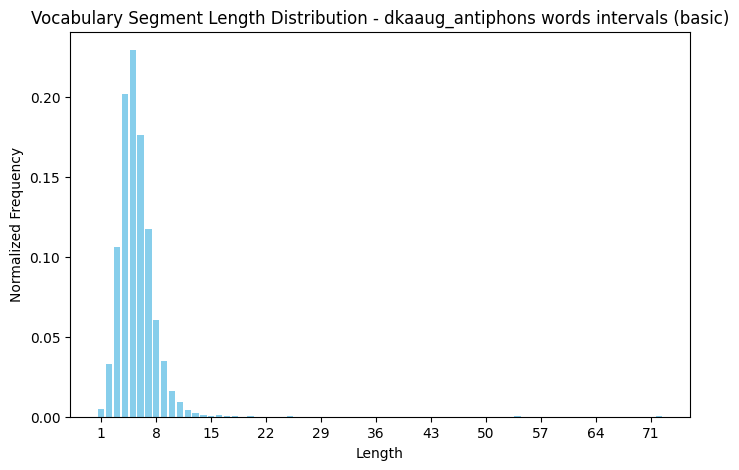

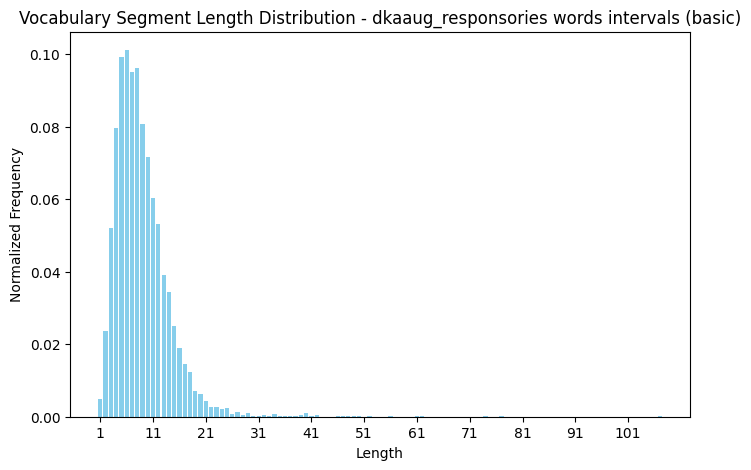

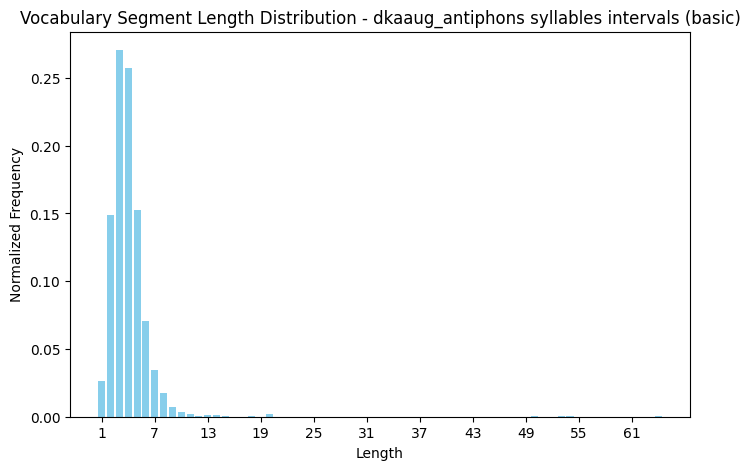

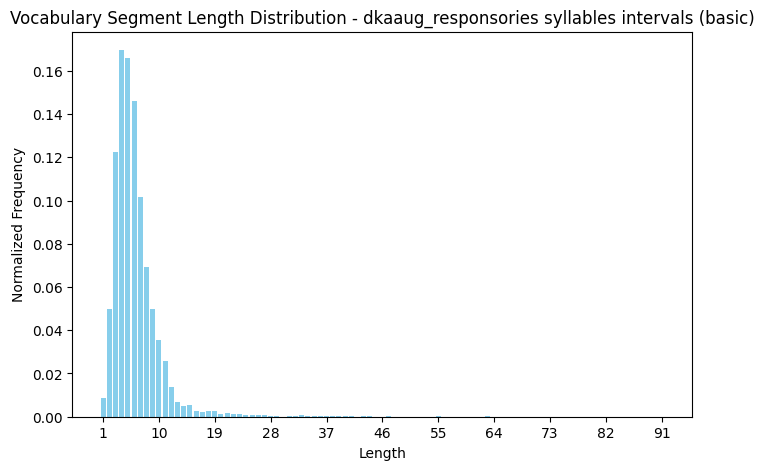

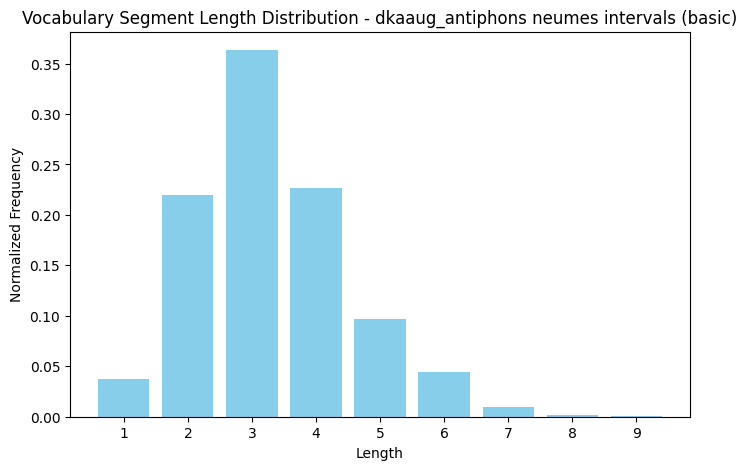

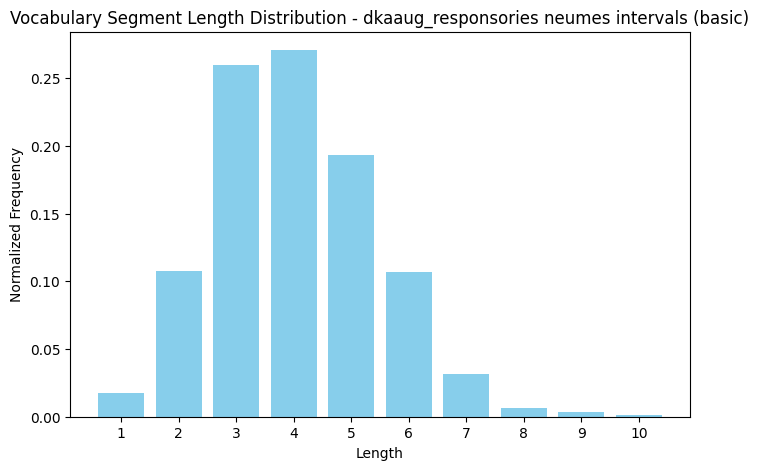

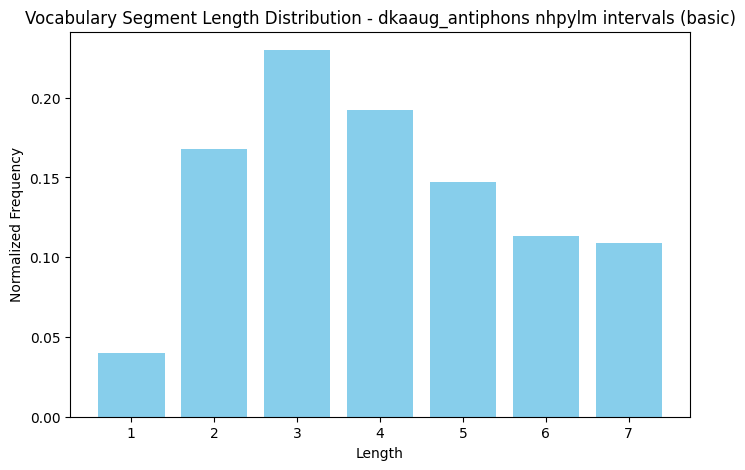

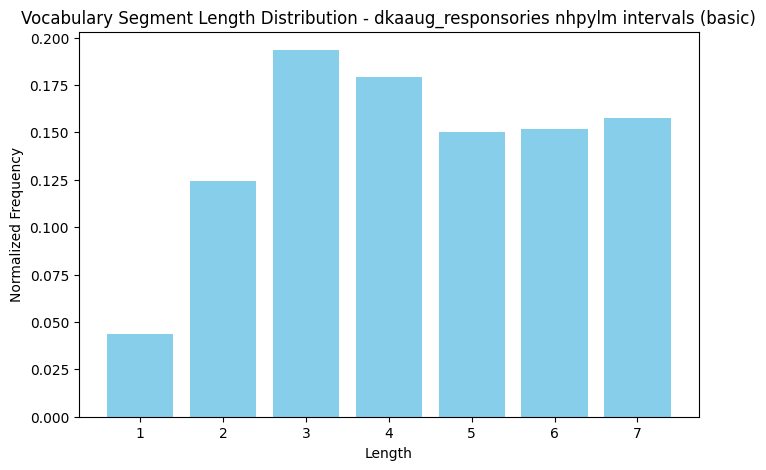

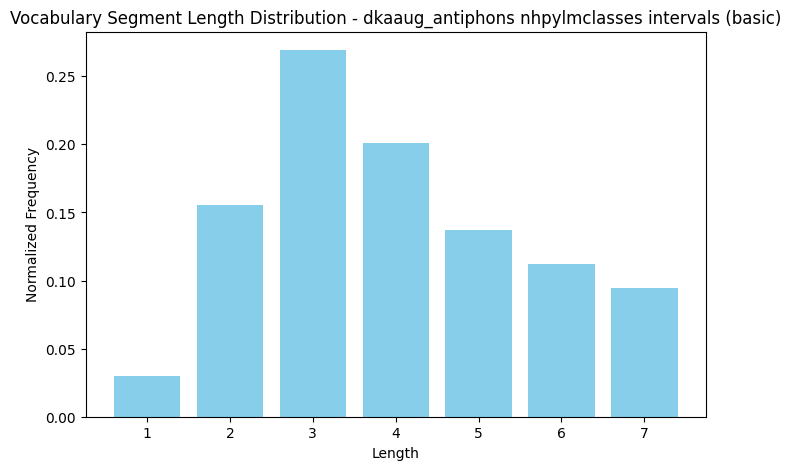

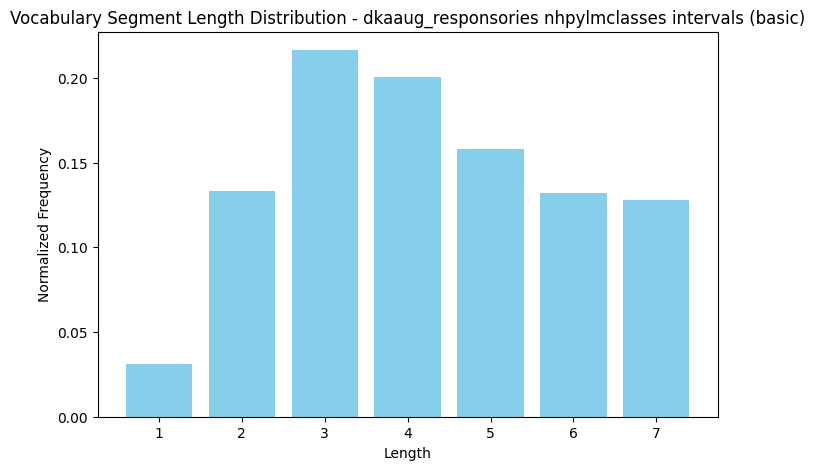

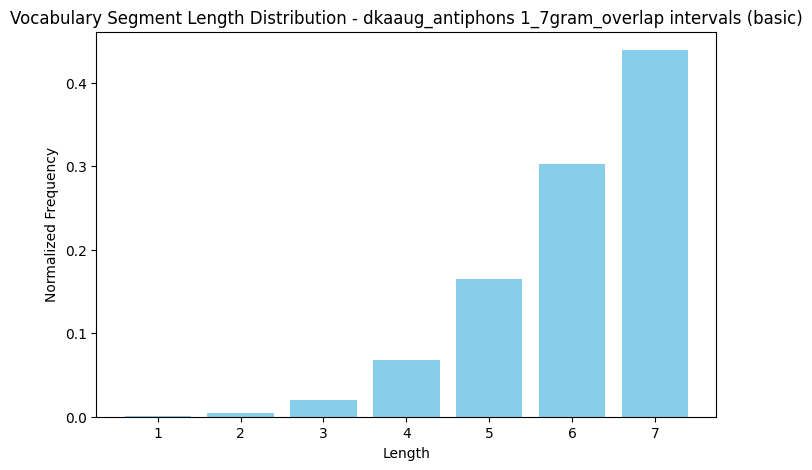

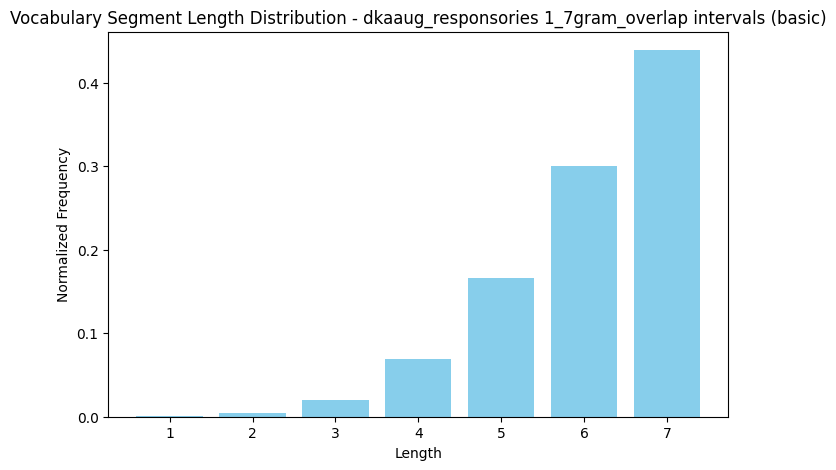

In [15]:
visualize_segment_lengths(
    directory = "classification_scores/", 
    dataset_types = ['dkaaug_antiphons', 'dkaaug_responsories'],  # ['all_antiphons', 'all_responsories', 'dkaaug_antiphons', 'dkaaug_responsories', 'sampled_antiphons', 'sampled_responsories']
    representations = ['intervals'],  # ['full_melodies', 'merged_tones', 'intervals']
    segmentation_approaches = ['words', 'syllables', 'neumes', 'nhpylm', 'nhpylmclasses', '1_7gram_overlap'], # ['words', 'syllables', 'neumes', 'nhpylm', 'nhpylmclasses', '1_7gram_overlap']
    experiment_mode = "basic" # 'basic', 'sci', 'sciliq', 'liq'
)


# Average Segment Lengths

### Print Function

In [16]:
import os
import json
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


def visualize_segment_lengths_of_position(directory, experiment1, experiment2, title):
    # Initialize data structure to hold scores by language and experiment
    
    basic = defaultdict(dict)
    sci = defaultdict(dict)
    sciliq = defaultdict(dict)
    liq = defaultdict(dict)

    experiment_modes = {
        "basic": basic,
        "sci": sci,
        "sciliq": sciliq,
        "liq": liq
    }

    
    seg_approaches = set()
    
    # Load each JSON file in the directory
    for file_path in glob.glob(os.path.join(directory, "*.json")):   
        with open(file_path, 'r') as json_file:
            scores = json.load(json_file)
            seg_approach, representation, dataset_type, other_args = file_path.split("#")
            seg_approach = seg_approach.split('/')[-1]
            seg_approaches.add(seg_approach)
            if "average_segment_lengths" and "uniqueness_density" not in scores["final"]:
                continue
            if other_args == ".json":
                if not representation in basic:
                    basic[representation] = {}
                if not seg_approach in basic[representation]:
                    basic[representation][seg_approach] = {}
                if not dataset_type in basic[representation][seg_approach]:
                    basic[representation][seg_approach][dataset_type] = {}
                basic[representation][seg_approach][dataset_type]["average_segment_lengths"] = scores["final"]["average_segment_lengths"]
                basic[representation][seg_approach][dataset_type]["uniqueness_density"] = scores["final"]["uniqueness_density"]
            elif other_args == "sci.json":
                if not representation in sci:
                    sci[representation] = {}
                if not seg_approach in sci[representation]:
                    sci[representation][seg_approach] = {}
                if not dataset_type in sci[representation][seg_approach]:
                    sci[representation][seg_approach][dataset_type] = {}
                sci[representation][seg_approach][dataset_type]["average_segment_lengths"] = scores["final"]["average_segment_lengths"]
                sci[representation][seg_approach][dataset_type]["uniqueness_density"] = scores["final"]["uniqueness_density"]
            elif other_args == "liq.json":
                if not representation in liq:
                    liq[representation] = {}
                if not seg_approach in liq[representation]:
                    liq[representation][seg_approach] = {}
                if not dataset_type in liq[representation][seg_approach]:
                    liq[representation][seg_approach][dataset_type] = {}
                liq[representation][seg_approach][dataset_type]["average_segment_lengths"] = scores["final"]["average_segment_lengths"]
                liq[representation][seg_approach][dataset_type]["uniqueness_density"] = scores["final"]["uniqueness_density"]
            elif other_args == "sciliq.json":
                if not representation in sciliq:
                    sciliq[representation] = {}
                if not seg_approach in sciliq[representation]:
                    sciliq[representation][seg_approach] = {}
                if not dataset_type in sciliq[representation][seg_approach]:
                    sciliq[representation][seg_approach][dataset_type] = {}
                sciliq[representation][seg_approach][dataset_type]["average_segment_lengths"] = scores["final"]["average_segment_lengths"]
                sciliq[representation][seg_approach][dataset_type]["uniqueness_density"] = scores["final"]["uniqueness_density"]
    

    #def plot_avg_seg_lengths_of_positions(data_avg1, data_avg2, data_uniq1, data_uniq2, title):
    #    plt.figure(figsize=(10, 5))
    #    plt.plot(np.arange(0.25, 100.25, 0.25), data)
    #    plt.title("Average Segment Lengths - "+ title)
    #    plt.xlabel("Chant Position (%)")
    #    plt.ylabel("Average Segment Length")
    #    #plt.ylim(1, 7)
    #    plt.grid(True)
    #    plt.show()

    def plot_dual_axis_avg_uniq(data_avg1, data_avg2, data_uniq1, data_uniq2, title):
        fig, ax1 = plt.subplots(figsize=(10, 5))
    
        x_avg = np.arange(0.25, 100.25, 0.25)
    
        # Barvy
        color_avg2 = 'darkorange'   
        color_avg1 = '#FF6600'
        color_uniq2 = 'dodgerblue'
        color_uniq1 = '#000080'   
        
        ax1.plot(x_avg, data_uniq1, linestyle='-', linewidth=4, color=color_uniq1, label="Uniqueness Pitches", zorder=3)
        ax1.plot(x_avg, data_uniq2, linestyle='--', linewidth=1, color=color_uniq2, label="Uniqueness Intervals", zorder=0)
        ax1.set_xlabel("Chant Position (%)", fontsize=18)
        ax1.set_ylabel("Unique Occurrences (%)", color=color_uniq1, fontweight='bold', fontsize=20)
        ax1.tick_params(axis='y', labelcolor=color_uniq1, labelsize=18)
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        ax2.plot(x_avg, data_avg1, linestyle='-', linewidth=4, color=color_avg1, label="Segment Length Pitches", zorder=4)
        ax2.plot(x_avg, data_avg2, linestyle='--', linewidth=1, color=color_avg2, label="Segment Length Intervals", zorder=1)
        ax2.set_ylabel("Segment Length", color=color_avg1, fontweight='bold', fontsize=26)  
        ax2.tick_params(axis='y', labelcolor=color_avg1, labelsize=18) 
    
    
        fig.suptitle(title, fontsize=28)
    
        # Spojená legenda
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2,  loc='upper center', fontsize=18)
    
        plt.show()
        

    mode1, rep1, seg1, data1 = experiment1
    mode2, rep2, seg2, data2 = experiment2
    plot_dual_axis_avg_uniq(experiment_modes[mode1][rep1][seg1][data1]["average_segment_lengths"], 
                            experiment_modes[mode2][rep2][seg2][data2]["average_segment_lengths"], 
                            experiment_modes[mode1][rep1][seg1][data1]["uniqueness_density"], 
                            experiment_modes[mode2][rep2][seg2][data2]["uniqueness_density"], 
                            title)
                
                

### Visualizations

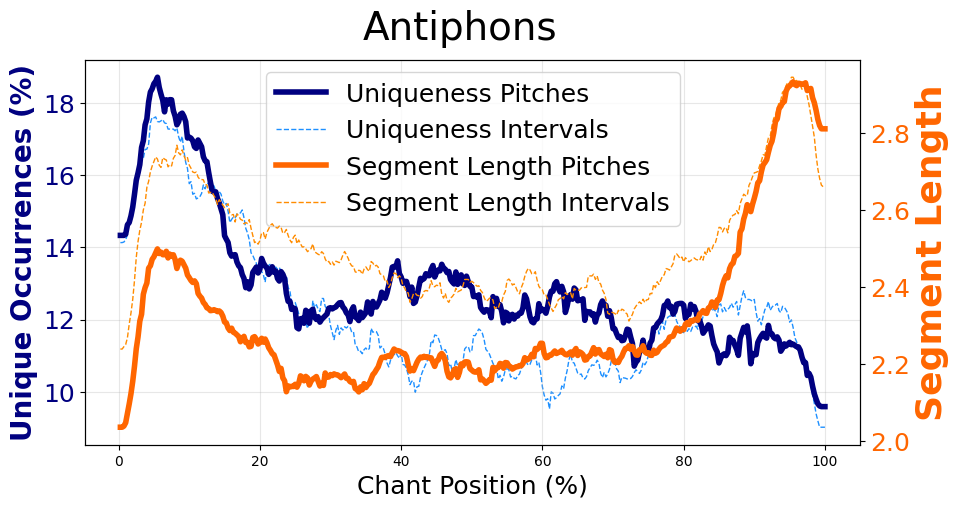

In [17]:
visualize_segment_lengths_of_position(
    directory = "classification_scores/",
    experiment1 = ('basic', 'full_melodies', 'nhpylmclasses', 'dkaaug_antiphons'),
    experiment2 = ('basic', 'intervals', 'nhpylmclasses', 'dkaaug_antiphons'),
    title="Antiphons"
)


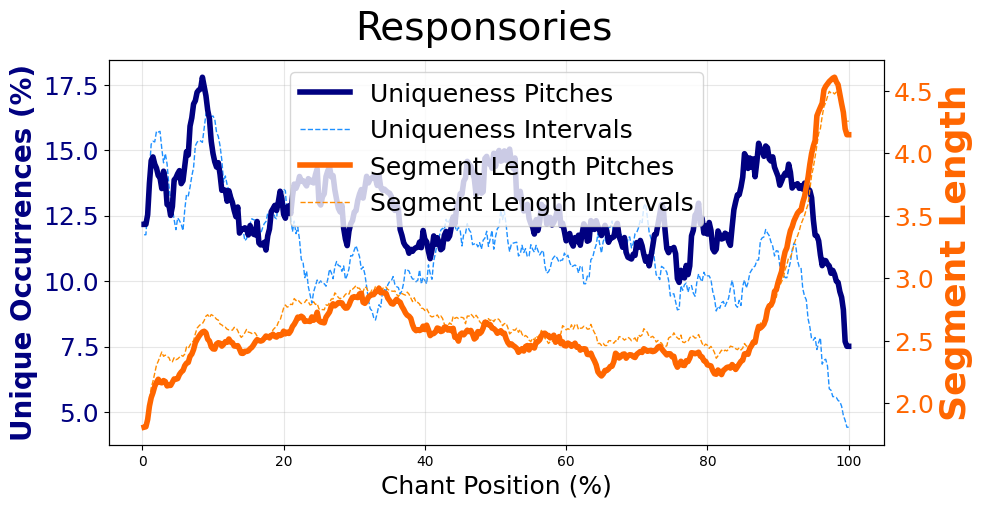

In [18]:
visualize_segment_lengths_of_position(
    directory = "classification_scores/",
    experiment1 = ('basic', 'full_melodies', 'nhpylmclasses', 'dkaaug_responsories'),
    experiment2 = ('basic', 'intervals', 'nhpylmclasses', 'dkaaug_responsories'),
    title="Responsories"
)
